In [26]:
# Thư viện đọc và xử lý dữ liệu
import pandas as pd
import numpy as np
from google.colab import drive
from sklearn.preprocessing import MinMaxScaler
# Thư viện train model dự đoán
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
# Thư viện vẽ biểu đồ
import matplotlib.pyplot as plt
# Thư viện đánh giá độ chính xác của model
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error

In [27]:
# Đọc dữ liệu
drive.mount('/content/drive')
path_data ="/content/drive/My Drive/Colab Notebooks/"
df = pd.read_csv(path_data + "Dữ liệu Lịch sử Hợp đồng Tương lai Vàng.csv")
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Ngày,Lần cuối,Mở,Cao,Thấp,KL,% Thay đổi
0,29/12/2023,2081.4,2087.2,2087.2,2080.8,0.06K,-0.56%
1,28/12/2023,2093.1,2109.1,2118,2094.6,8.11K,0.00%
2,27/12/2023,2093.1,2079.3,2095.8,2072.8,128.18K,1.13%
3,26/12/2023,2069.8,2066,2080.5,2065.1,79.57K,0.03%
4,22/12/2023,2069.1,2061.2,2083,2058.2,170.15K,0.87%


In [28]:
# Đổi tên và xóa nhưng cột không cần thiết
df.columns = ['Date', 'final', 'Open', 'High', 'Low', 'KL', "Change"]
df = df.drop(['KL','Change'], axis=1)
df.head()

,Date,final,Open,High,Low
0,29/12/2023,2081.4,2087.2,2087.2,2080.8
1,28/12/2023,2093.1,2109.1,2118,2094.6
2,27/12/2023,2093.1,2079.3,2095.8,2072.8
3,26/12/2023,2069.8,2066,2080.5,2065.1
4,22/12/2023,2069.1,2061.2,2083,2058.2


In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6077 entries, 0 to 6076
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    6077 non-null   object
 1   final   6077 non-null   object
 2   Open    6077 non-null   object
 3   High    6077 non-null   object
 4   Low     6077 non-null   object
dtypes: object(5)
memory usage: 237.5+ KB


In [30]:
# Xử lý các kiểu dữ liệu object về dạng datetime và float
df['Date']= pd.to_datetime(df['Date'], format='%d/%m/%Y')
df['final'] = pd.to_numeric(df['final'].str.replace(',', ''), errors='coerce')
df['Open'] = pd.to_numeric(df['Open'].str.replace(',', ''), errors='coerce')
df['High'] = pd.to_numeric(df['High'].str.replace(',', ''), errors='coerce')
df['Low'] = pd.to_numeric(df['Low'].str.replace(',', ''), errors='coerce')

In [31]:
df.describe()

,Date,final,Open,High,Low
count,6077,6077.000000,6077.000000,6077.000000,6077.000000
mean,2012-01-29 00:27:29.234819840,1091.544677,1091.663897,1099.680698,1083.156475
min,2000-01-04 00:00:00,256.600000,256.600000,258.400000,255.100000
25%,2006-02-03 00:00:00,553.500000,553.100000,557.200000,546.500000
50%,2012-02-07 00:00:00,1213.400000,1213.500000,1220.900000,1204.300000
75%,2018-02-09 00:00:00,1516.900000,1518.300000,1530.300000,1505.200000
max,2023-12-29 00:00:00,2093.100000,2109.100000,2152.300000,2094.600000
std,NaN,541.995194,542.235830,545.653705,538.326845


In [32]:
# Tạo ra một dataframe mới và biến cột 'Date' thành dạng index
df1 = pd.DataFrame(df,columns = ['Date', 'final'])
df1.set_index('Date', drop=True, inplace=True)
df1 = df1[::-1]

In [33]:
df1

,final
Date,
2000-01-04,283.7
2000-01-05,282.1
2000-01-06,282.4
2000-01-07,282.9
2000-01-10,282.7
...,...
2023-12-22,2069.1
2023-12-26,2069.8
2023-12-27,2093.1


In [34]:
# Chia tập dữ liệu ra để train và test
data = df1.values
train_data = data[:5000]
test_data = data[5000:]

In [35]:
# Chuẩn hóa dữ liệu về dạng từ 0 đến 1
sc = MinMaxScaler(feature_range=(0,1))
train_data_scaled = sc.fit_transform(train_data)

In [36]:
# Sử dụng 60 dữ liệu để dự đoán dữ liệu tiếp theo
X_train, y_train = [], []
for i in range(60, len(train_data)):
  X_train.append(train_data_scaled[i-60:i, 0])
  y_train.append(train_data_scaled[i, 0])

In [37]:
# Dữ liệu đầu vào để dự đoán mô hình
X_train[0:2]

[array([0.01657188, 0.01559347, 0.01577692, 0.01608268, 0.01596037,
        0.01699994, 0.01657188, 0.01742799, 0.01730569, 0.02017978,
        0.02060784, 0.01999633, 0.02024093, 0.01926252, 0.01834526,
        0.01828411, 0.01865101, 0.01797835, 0.01810065, 0.01761145,
        0.01901792, 0.02036324, 0.03448908, 0.02929126, 0.02757904,
        0.03179845, 0.03797468, 0.03485599, 0.03326607, 0.02904666,
        0.02959702, 0.02886321, 0.03100349, 0.03124809, 0.02800709,
        0.02708983, 0.02323733, 0.02299272, 0.02299272, 0.02244237,
        0.02024093, 0.02060784, 0.02005748, 0.02268697, 0.02066899,
        0.02207546, 0.02042439, 0.02134165, 0.02024093, 0.02017978,
        0.01858986, 0.01736684, 0.01828411, 0.02066899, 0.01938482,
        0.01761145, 0.01742799, 0.01461506, 0.01400355, 0.01180212]),
 array([0.01559347, 0.01577692, 0.01608268, 0.01596037, 0.01699994,
        0.01657188, 0.01742799, 0.01730569, 0.02017978, 0.02060784,
        0.01999633, 0.02024093, 0.01926252, 0.

In [38]:
# Kết quả dự đoán
y_train[0:2]

[0.013758943313153554, 0.015165413074053669]

In [39]:
# Biến đổi dữ liệu của tập trên thành các mảng để phù hộ với model khi đữ vào train
X_train, y_train = np.array(X_train), np.array(y_train)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
y_train = np.reshape(y_train, (y_train.shape[0], 1))




In [40]:
X_train.shape

(4940, 60, 1)

In [41]:
y_train.shape

(4940, 1)

In [42]:
# Khởi tạo mô hình tuần tự (Sequential) cho mạng nơ-ron
model = Sequential()
# Thêm lớp LSTM đầu tiên với 128 đơn vị ẩn và chuỗi đầu ra
model.add(LSTM(units=128, return_sequences=True, input_shape=(X_train.shape[1], 1)))

# Thêm lớp LSTM thứ hai với 64 đơn vị ẩn, không trả về chuỗi
model.add(LSTM(units = 64))

# Thêm lớp Dropout với tỷ lệ 0.5 để giảm overfitting
model.add(Dropout(0.5))

# Thêm lớp Dense với 1 đơn vị đầu ra cho giá trị dự đoán
model.add(Dense(1))

# Biên dịch mô hình với hàm mất mát MSE và thuật toán tối ưu Adam
model.compile(loss='mean_squared_error', optimizer='adam')


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [43]:
# Đường dẫn lưu mô hình tốt nhất
save_model = "save_model.keras"

# Callback lưu mô hình khi 'loss' đạt tốt nhất
best_model = ModelCheckpoint(save_model, monitor='loss', verbose=2, save_best_only=True, mode='auto')

# Huấn luyện mô hình với 30 epochs, batch_size 50 và callback lưu mô hình tốt nhất
model.fit(X_train, y_train, epochs=30, batch_size=50, verbose = 2, callbacks=[best_model])

Epoch 1/30

Epoch 1: loss improved from inf to 0.01072, saving model to save_model.keras
99/99 - 20s - 207ms/step - loss: 0.0107
Epoch 2/30

Epoch 2: loss improved from 0.01072 to 0.00481, saving model to save_model.keras
99/99 - 21s - 214ms/step - loss: 0.0048
Epoch 3/30

Epoch 3: loss improved from 0.00481 to 0.00441, saving model to save_model.keras
99/99 - 20s - 199ms/step - loss: 0.0044
Epoch 4/30

Epoch 4: loss improved from 0.00441 to 0.00407, saving model to save_model.keras
99/99 - 21s - 207ms/step - loss: 0.0041
Epoch 5/30

Epoch 5: loss improved from 0.00407 to 0.00372, saving model to save_model.keras
99/99 - 21s - 212ms/step - loss: 0.0037
Epoch 6/30

Epoch 6: loss improved from 0.00372 to 0.00339, saving model to save_model.keras
99/99 - 20s - 201ms/step - loss: 0.0034
Epoch 7/30

Epoch 7: loss improved from 0.00339 to 0.00329, saving model to save_model.keras
99/99 - 20s - 204ms/step - loss: 0.0033
Epoch 8/30

Epoch 8: loss improved from 0.00329 to 0.00288, saving model 

In [44]:
# Chuyển đổi ngược y_train về giá trị gốc (bỏ chuẩn hóa)
y_train = sc.inverse_transform(y_train)

# Tải mô hình đã lưu tốt nhất từ file
final_model = load_model('save_model.keras')

# Dự đoán trên dữ liệu huấn luyện với mô hình đã lưu
y_train_pred = final_model.predict(X_train)

# Chuyển đổi ngược y_train_pred về giá trị gốc
y_train_pred = sc.inverse_transform(y_train_pred)


155/155 ━━━━━━━━━━━━━━━━━━━━ 8s 52ms/step


In [45]:
final_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 60, 128)             │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 348,101 (1.33 MB)

 Trainable params: 116,033 (453.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 232,068 (906.52 KB)

In [46]:
# Chuẩn bị dữ liệu kiểm tra từ df1
test = df1[len(train_data)-60:].values
test = test.reshape(-1, 1)

# Chuẩn hóa dữ liệu kiểm tra
sc_test = sc.transform(test)

# Tạo tập dữ liệu đầu vào X_test cho mô hình với cửa sổ thời gian 60 bước
X_test = []
for i in range(60, test.shape[0]):
  X_test.append(sc_test[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Gán nhãn thực tế cho dữ liệu kiểm tra
y_test = data[5000:]

# Dự đoán trên tập kiểm tra và chuyển đổi ngược giá trị dự đoán về giá trị gốc
y_test_pred = final_model.predict(X_test)
y_test_pred = sc.inverse_transform(y_test_pred)


34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step


In [47]:
test

array([[1478.3],
       [1513.2],
       [1503.1],
       ...,
       [2093.1],
       [2093.1],
       [2081.4]])

<ipython-input-48-296a8f0a2b25>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data1['prediction'] = y_train_pred
<ipython-input-48-296a8f0a2b25>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data1['prediction'] = y_test_pred


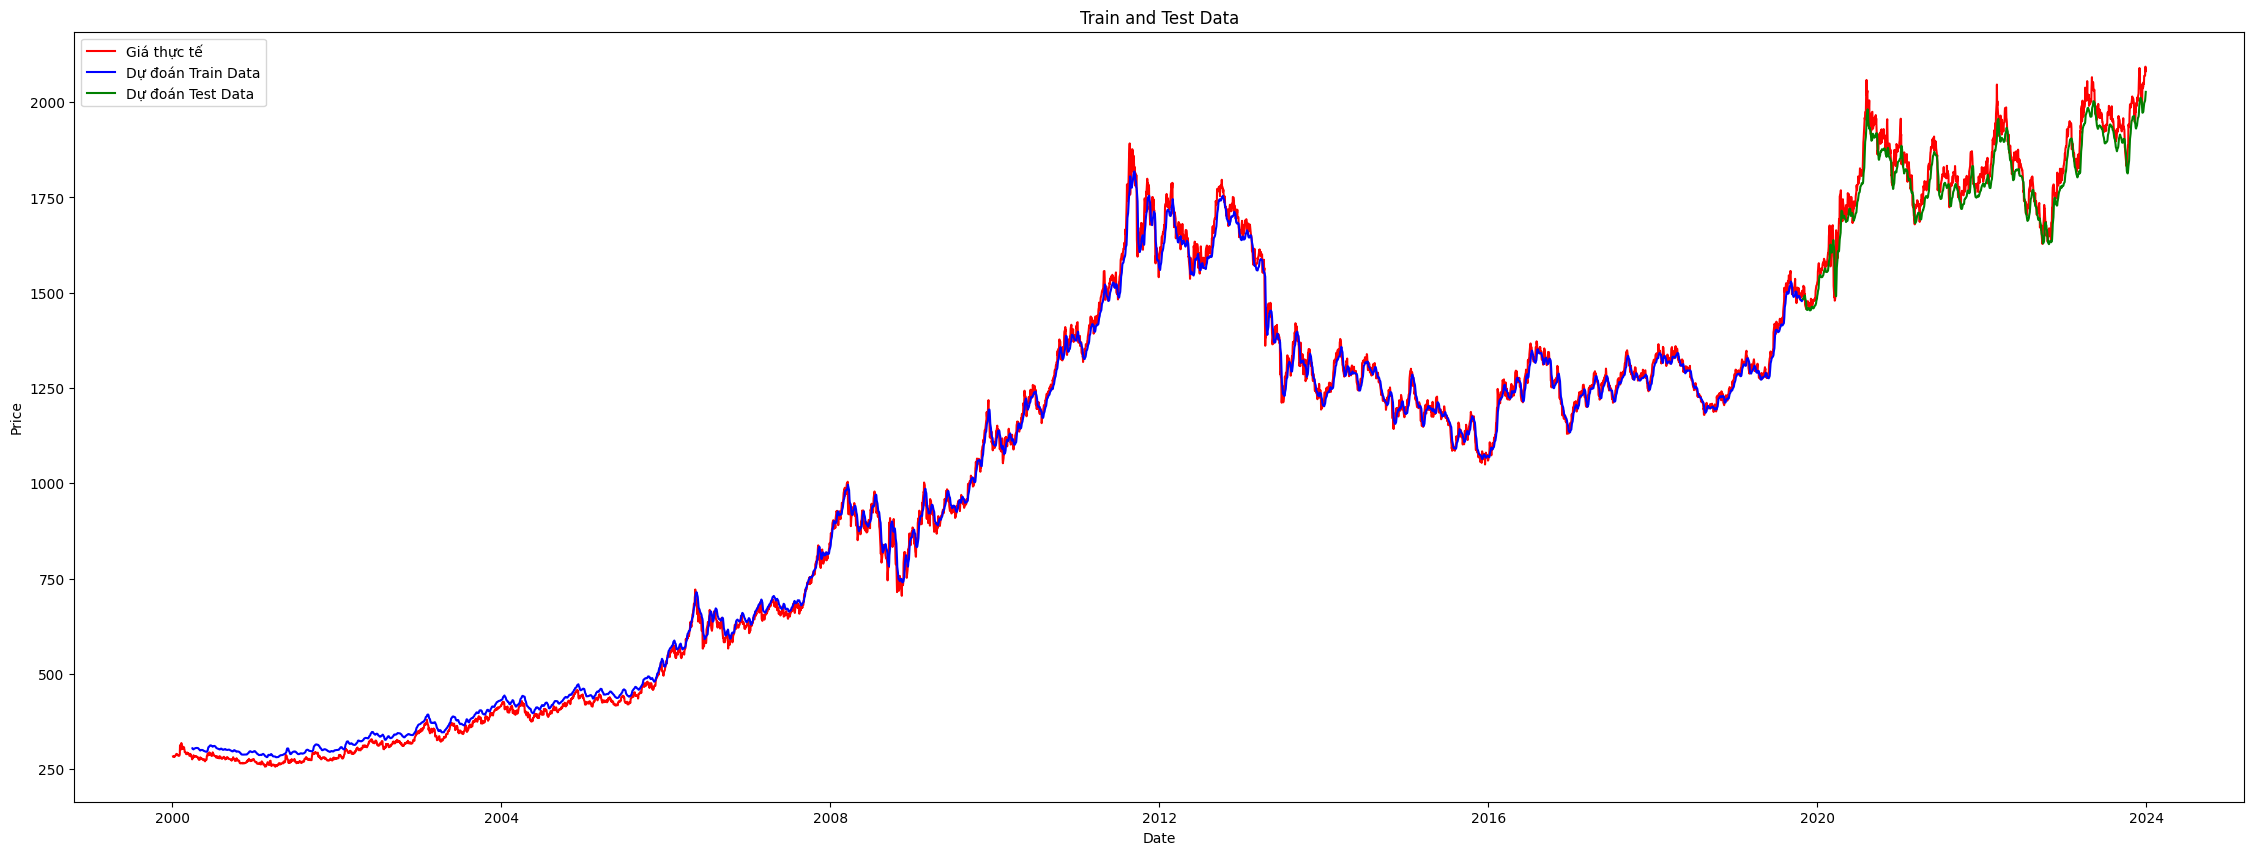

In [48]:
train_data1 = df1[60:5000]
test_data1 = df1[5000:]
# Vẽ biểu đồ đường để hiên thị dữ liệu thực tế, dữ liệu được huấn luyện và dữ liệu test
plt.figure(figsize=(28, 10))
plt.plot(df1, label='Giá thực tế',color = 'red')
train_data1['prediction'] = y_train_pred
test_data1['prediction'] = y_test_pred
plt.plot(train_data1['prediction'], label='Dự đoán Train Data', color='blue')
plt.plot(test_data1['prediction'], label='Dự đoán Test Data', color='green')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Train and Test Data')
plt.legend()
plt.show()

In [49]:
print("Sai số tuyệt đối trung bình tập train:",mean_squared_error(y_train, y_train_pred))
print("Độ phù hợp tập train:",r2_score(y_train, y_train_pred))
print(f"Phần trăm sai số tuyệt đối của trung bình của tập train: {round(mean_absolute_percentage_error(y_train, y_train_pred)*100,4)}%")

Sai số tuyệt đối trung bình tập train: 521.8531661478632
Độ phù hợp tập train: 0.9975345412808666
Phần trăm sai số tuyệt đối của trung bình của tập train: 2.8516%


In [50]:
print("Sai số tuyệt đối trung bình tập test:",mean_squared_error(y_test, y_test_pred))
print("Độ phù hợp tập test:",r2_score(y_test, y_test_pred))
print(f"Phần trăm sai số tuyệt đối của trung bình của tập test: {round(mean_absolute_percentage_error(y_test, y_test_pred)*100,4)}%")

Sai số tuyệt đối trung bình tập test: 1830.3014282187185
Độ phù hợp tập test: 0.8972993346983742
Phần trăm sai số tuyệt đối của trung bình của tập test: 1.9547%


In [51]:
test_data1

,final,prediction
Date,,
2019-10-29,1490.7,1483.391602
2019-10-30,1500.2,1483.260620
2019-10-31,1518.3,1483.607910
2019-11-01,1514.9,1486.509033
2019-11-04,1514.7,1489.915894
...,...,...
2023-12-22,2069.1,1997.400513
2023-12-26,2069.8,2004.028687
2023-12-27,2093.1,2010.375122
